# RawalNet

In [1]:
## import necessary Libs

##b basic
import matplotlib.pyplot as plt
import numpy as np
import os

## torch functionalities
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim

In [2]:
## set up the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load in the data

In [3]:
## define the transform
transform = transforms.Compose([
                  transforms.Resize((224,224)),
                  transforms.RandomHorizontalFlip(10),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
## define batch_size
batch_size = 4
## validation data
valid_size = 0.2

train_set = torchvision.datasets.ImageFolder(root='./simpsons/train/',transform=transform)
test_set = torchvision.datasets.ImageFolder(root='./simpsons/validation/',transform=transform)

## split into train and valid set
num_train = len(train_set)
print('Total datapoints in train_set : {}'.format(num_train))
indices = list(range(num_train)) ## a list 0-num_train
np.random.shuffle(indices) ## shuffle the indices for split
split_idx = int(np.floor(valid_size*num_train)) ## where to split the data
train_idx,valid_idx = indices[split_idx:],indices[:split_idx]

## create subset samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

## Make the dataLoaders
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

## specify the classes
classes = sorted(os.listdir('./simpsons/train'))

Total datapoints in train_set : 19548


In [5]:
## function to visualize a batch in dataLoader

def imshow(loader):
    
    images,labels = next(iter(loader)) ## get the iamge and title
    img = torchvision.utils.make_grid(images)
    title = [classes[i.item()] for i in labels] ## list of titles
    ## unnormalize the image
    std = np.asarray([0.5,0.5,0.5]).reshape(3,1,1) 
    mean = np.asarray([0.5,0.5,0.5]).reshape(3,1,1)
    
    npimg = np.multiply(img.numpy(),std)+mean
    
    plt.figure(figsize=(10*batch_size,8))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title,fontsize=40)
    plt.show()
    

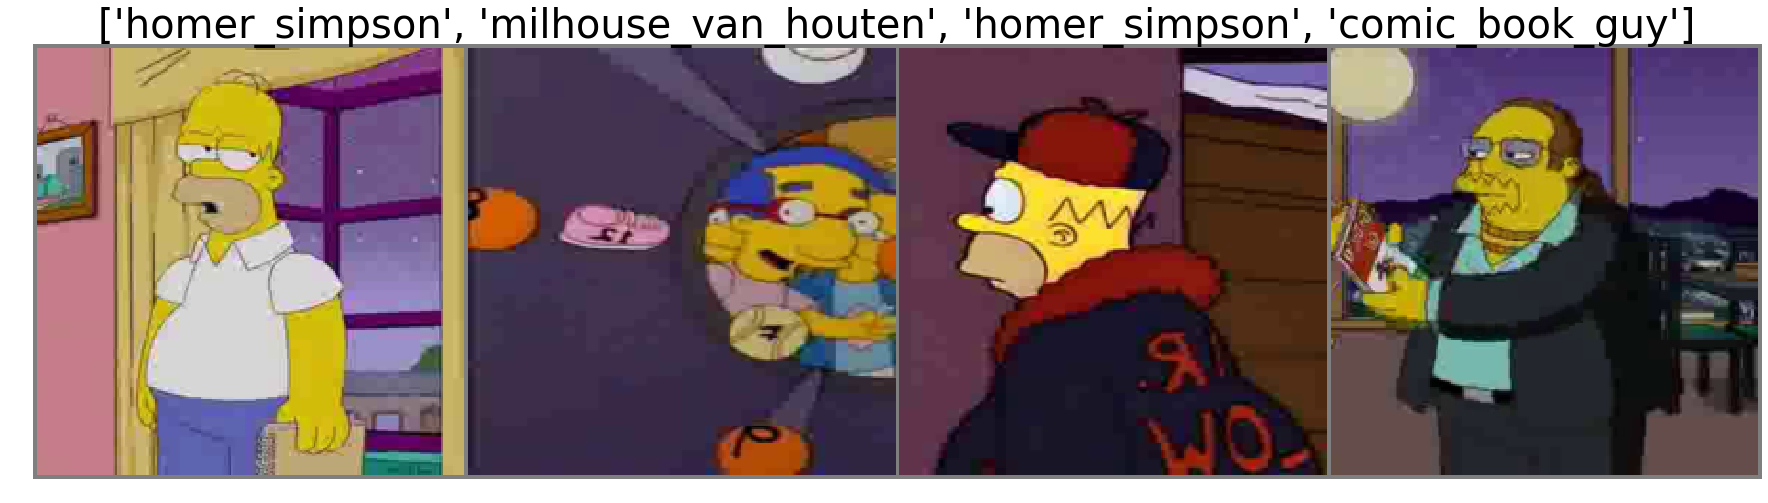

In [6]:
## visualize the input
imshow(train_loader)

## Make the Network

In [7]:
from torchvision import models

In [8]:
vgg = models.vgg16_bn()


## change the final layer
final_in_feat = vgg.classifier[6].in_features
vgg.classifier[6] =  nn.Linear(final_in_feat,1000) ## number of output calsses
vgg.classifier = nn.Sequential(*(vgg.classifier[i] for i in range(7)),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(1000,20))

print(vgg)
vgg = vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [9]:
## specify loss and optimizer

criterion = nn.CrossEntropyLoss() ## multiclass classification/

optim = optim.SGD(vgg.parameters(),lr=0.001) ## define the optimizer

In [10]:
def evaluate(loader,model_e):
    total,correct = 0,0
    for data in loader:
        images,target = data
        images,target = images.to(device),target.to(device)
        outputs = model_e(images)
        _,pred = torch.max(outputs.data,1)
        total += target.size(0) ## add batch_size
        correct += (pred == target).sum().item()
    return 100*(correct/total)

In [ ]:
## Train the network
n_epochs = 10

valid_loss_min = np.Inf ## to track how the validation loss is changing
train_loss_ep = []
valid_loss_ep = []

for epoch in range(1,n_epochs+1):
    ## for each epoch
    train_loss = 0.0
    valid_loss = 0.0
    
    ## it's time to train
    vgg.train()
    for batch_idx,(images,target) in enumerate(train_loader):
        
        images,target = images.cuda(),target.cuda() ## shift them to gpu's
        
        ## clear the optimizer grad's
        optim.zero_grad() 
        output = vgg(images) ## send one batch
        
        if epoch==1:
            print(output)
        
        ## do a backward pass
        loss = criterion(output,target)
        loss.backward()
        optim.step() ## do optimization
        
        train_loss += loss.item()*images.size(0) ## update the loss
        
    ## validation time
    vgg.eval()
    for batch_idx,(images,target) in enumerate(valid_loader):
        images,target = images.cuda(),target.cuda()
        
        output = vgg(images)
        loss = criterion(output,target)
        valid_loss += loss.item()*images.size(0)
        
        
    
        
    train_loss = train_loss/len(train_loader.sampler) ## total smaples
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    train_loss_ep.append(train_loss)
    valid_loss_ep.append(valid_loss)
    
    acc = evaluate(train_loader,vgg)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuaracy:{}'.format(epoch,train_loss,valid_loss,acc))
    
    if valid_loss<valid_loss_min:
        print('Validation Loss decreased form {:.6f} to {:.6f}'.format(valid_loss_min,valid_loss))
        ## save the model
        torch.save(vgg.state_dict(),'RawalNet.pt')
        valid_loss_min = valid_loss

In [11]:
vgg.load_state_dict(torch.load('RawalNet.pt')) ## load in the model

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
evaluate(test_loader,vgg)

82.02020202020202

In [14]:
def test_imshow(loader,model):
    images,targets = next(iter(loader)) ## get the images 
    title = classes[targets[0].item()]
    output = model(images.to(device))
    _,labels = torch.max(output,1)
    label = classes[labels[0].item()]
    images = images.numpy()
    
    std = np.asarray([0.5,0.5,0.5]).reshape(3,1,1) 
    mean = np.asarray([0.5,0.5,0.5]).reshape(3,1,1)
    
    images = np.multiply(images,std)+mean
    npimg = images[0,:,:,:]
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Truth:{}   Pred:{}'.format(title,label),fontsize=40)
    plt.show()

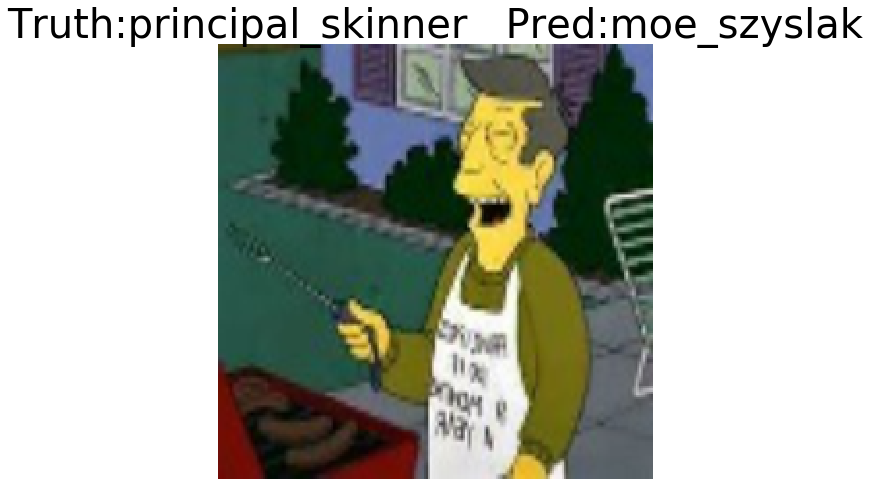

In [28]:
test_imshow(test_loader,vgg)